Why learn jax:</br>
It is extremely fast
How is jax faster than pytorch?</br>
Because jax uses just in time compilation compared to pytorchs dynamic graph construction.

1. Jax functions should not have side effects ==> they are not allowed to affect any variable outside of their namespaces.
2. Jax compiles functions based on anticipated shapes of all arrays/tensors in the function. This can be problematic when shapes or progrmam flow within the function depends on the values of the tensors (e.g y = x[x>=2]. Here the shape of y is determined by how many values in x are greater than 2.)

More resources:
1. Jax 101 
2. Jax the sharp bits.
3. Jax for impatient
4. Flax basics.

In [29]:
# import standard libraris
import os
import math
import numpy as np  
import time

# imports for plotting.
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # for exports
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## progress bar
from tqdm.auto import tqdm

/var/folders/9d/yx8gqbb90hbg0j25szlgylq00000gp/T/ipykernel_3971/2920860919.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # for exports


## Jax as NumPy on accelerators.

In [7]:
import jax
import jax.numpy as jnp
print('Using jax version', jax.__version__)

Using jax version 0.4.35


In [8]:
a = jnp.zeros((2, 3), dtype= jnp.float32)
print(a)

[[0. 0. 0.]
 [0. 0. 0.]]


In [9]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [10]:
b.__class__

jaxlib.xla_extension.ArrayImpl

Unlike numpy arrays, jax arrays can execute the same code on different backends like cpus, gpus or tpus. Hence, device arays represent an array on one of the backends. we can check the device of an array using

In [11]:
b.device

CpuDevice(id=0)

It would have been on gpu if there is one! But inorder to make the array on cpu we can use:

In [12]:
b_cpu = jax.device_get(b) 
print(b_cpu.__class__)

<class 'numpy.ndarray'>


To explicitly push the Numpy array to GPU use jax.device_put()

In [13]:
b_gpu = jax.device_put(b_cpu)
print(b_gpu.__class__)

<class 'jaxlib.xla_extension.ArrayImpl'>


Jax handles the device clash itself. 

In [14]:
b_cpu + b_gpu 

Array([ 0,  2,  4,  6,  8, 10], dtype=int32)

Print all the available devices

In [15]:
jax.devices()

[CpuDevice(id=0)]

## Immutable tensors

Numpy arrays are mutable meaning the value of array elemets can be changed in place. example: b[0] = 2. Device arrays are immutable. No inplace operations are possible (jax requires programs to be pure functions). We use b.at[0].set(1) which returns a new array  

In [16]:
b_new = b.at[0].set(1)
print('original array', b)
print('new array', b_new)

original array [0 1 2 3 4 5]
new array [1 1 2 3 4 5]


## Pseudo Random numbers in Jax

To avoid automatic change of seed outside the namespace, in jax we need to pass the seed to generate a random number.

In [17]:
rng = jax.random.PRNGKey(42)

In [18]:
## not an ideal way of generating random numbers
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print('jax_random_number_1', jax_random_number_1)
print('jax_random_number_2', jax_random_number_2)


jax_random_number_1 -0.18471177
jax_random_number_2 -0.18471177


That produced same random number because of PRNGKey. One can always get new keys by splitting the old one

In [19]:
np.random.seed(42) # set the seed
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()

print('numpy_random_number_1: ',np_random_number_1) 
print('numpy_random_number_2: ',np_random_number_2) 



numpy_random_number_1:  0.4967141530112327
numpy_random_number_2:  -0.13826430117118466


Two different numbers since the key (state of the random number generator) changes. Not allowed in jax --> side-effects

In [20]:
rng, subkey1, subkey2 = jax.random.split(rng, num= 3)
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print("jax_random_number_1 ", jax_random_number_1)
print("jax_random_number_2 ", jax_random_number_2)

jax_random_number_1  0.107961535
jax_random_number_2  -1.2226542


Function transformations with Jaxpr.
1. Always write the code in the form of pure functions => no side effects.
2. Jaxpr: Jax transforms a given function to a small and well behaved intermediate form. We can check which operations are performed on which array and what shapes the arrays are.
3. Then based on the the jaxpr, jax then interprets the function with transformation-specific interpretation rules: automatic differentiation or compiling a function in XLA to efficiently use the accelerator.

Lets use the below function to understand the jaxpr transformation.
$$y = 1/|x| \sum_i \left[(x_i + 2)^2 +3\right]$$

In [25]:
def simple_graph(x):
    x = x + 2
    x = x**2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype= jnp.float32)
print("input: ", inp)
print("output: ", simple_graph(inp))

input:  [0. 1. 2.]
output:  12.666667


In [22]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

Lets look at the jaxpr representation of a function with side-effects

In [23]:
global_list = []

def norm(x):
    global_list.append(x) # making changes to a global variable --> not a pure function.
    x = x**2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

jax.make_jaxpr(norm)(inp)


{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

Jaxpr ignored the operation with side effects!

## Automatic differentiation

Jax takes a function and gives us another function which directly computes the gradients for it.

In [24]:
# jax.grad
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradients', gradients)

Gradients [1.3333334 2.        2.6666667]


In [25]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[broadcast_dimensions=() shape=(3,)] h
    j:f32[3] = mul i e
  in (j,) }

In [26]:
# both value and gradient of a function for an input.
val_grad_funct = jax.value_and_grad(simple_graph)
val_grad_funct(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

# Pytree

Pytrees help us in dealing with nested structures.

In [ ]:
# example:
import jax
import jax.numpy as jnp

example_tree = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1':2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]) # itself is a leaf
]

# print how many leaves the pytrees have
for pytree in example_tree:
    # this 'jax.tree.leaves()' method extracts the flattened leaves from pytree
    leaves = jax.tree.leaves(pytree)
    print(f'{repr(pytree): <45} has length {len(leaves)} leaves: {leaves}')


<class 'list'>
[1, 'a', <object object at 0x10765bd20>]      has length 3 leaves: [1, 'a', <object object at 0x10765bd20>]
<class 'list'>
(1, (2, 3), ())                               has length 3 leaves: [1, 2, 3]
<class 'list'>
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has length 5 leaves: [1, 2, 3, 4, 5]
<class 'list'>
{'a': 2, 'b': (2, 3)}                         has length 3 leaves: [2, 2, 3]
<class 'list'>
Array([1, 2, 3], dtype=int32)                 has length 1 leaves: [Array([1, 2, 3], dtype=int32)]


1. lists, tuples, and dicts are considered as pytree.
2. Any object that is not in the pytree registry is treated as leaf.
3. pytree registry can be extended to user defined contained  classes.


# Common Pytree functions.

1. jax.tree.map

In [29]:
list_of_lists = [
    [1, 2, 3],
    [1,2],
    [1, 2, 3, 4]
]

jax.tree.map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

Jax.tree.map also allows mapping a N-ary function over multiple arguments. 

In [30]:
another_list_of_lists  = list_of_lists
jax.tree.map(lambda x, y: x + y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

When using the multiple arguments with jax.tree.map, the structure of the inputs must match. 

## jax.tree.map with ML model parameters.

pytrees can be useful in training a MLP.


In [2]:
import numpy as np
def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(
                weights = np.random.normal(size= (n_in, n_out))*np.sqrt(2/n_in),
                biases = np.ones(shape= (n_out,))
            )
        )

    return params

params = init_mlp_params([1, 128, 128, 1])


In [5]:
# use jax.tree.map to check the shapes of the inital parameters

jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [6]:
# define a function for training the mlp model:
# define forward pass
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x@layer['weights'] + layer['biases'])
        return x@last['weights'] +last['biases']

# define the loss function:
def loss_fn(params, x, y):
    return jnp.mean((forward(params, x)-y)**2)

# learning rate
LEARNING_RATE = 1e-4

# using the stochastic gradient descent:
@jax.jit
def update(params, x, y):
    # calculate the gradients with jax.grad
    grads = jax.grad(loss_fn)(params, x, y)
    # grads is a pytree with same structure as 'params'
    # You can apply the SGD update using JAX pytree
    return jax.tree.map(
        lambda p, g: p - LEARNING_RATE*g, params, grads
    )

(1000, 1) (1000, 1)


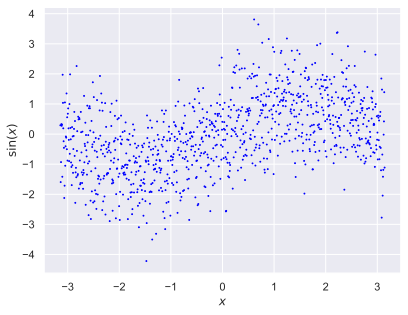

In [20]:
# lets run it for say 100 epochs
key = jax.random.PRNGKey(42)
# lets sample data from sine function
x = jnp.linspace(-jnp.pi, jnp.pi, 1000)
y = jnp.sin(x) 
noise = jax.random.normal(key, shape= (1000,))
y = y + noise

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

fig = plt.figure()
plt.scatter(x, y, color = 'blue', s = 1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\sin(x)$')
plt.show()

In [21]:
# quick check to see if the grads are of same structure as of the params.
grads = jax.grad(loss_fn)(params, x, y)

jax.tree.map(lambda x: x.shape, grads)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [24]:
# lets train for few epochs
epochs  = 100
for epoch in tqdm(range(epochs)):
    params = update(params, x, y)
    loss = loss_fn(params, x, y)
    print(f'epoch: {epoch+1}, loss: {loss}')



  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1, loss: 3.0375242233276367
epoch: 2, loss: 2.829130172729492
epoch: 3, loss: 2.644914150238037
epoch: 4, loss: 2.482069253921509
epoch: 5, loss: 2.338113784790039
epoch: 6, loss: 2.210855484008789
epoch: 7, loss: 2.0983550548553467
epoch: 8, loss: 1.9988994598388672
epoch: 9, loss: 1.9109736680984497
epoch: 10, loss: 1.8332393169403076
epoch: 11, loss: 1.7645134925842285
epoch: 12, loss: 1.7037498950958252
epoch: 13, loss: 1.6500247716903687
epoch: 14, loss: 1.6025201082229614
epoch: 15, loss: 1.5605144500732422
epoch: 16, loss: 1.5233689546585083
epoch: 17, loss: 1.4905197620391846
epoch: 18, loss: 1.4614678621292114
epoch: 19, loss: 1.435772180557251
epoch: 20, loss: 1.41304349899292
epoch: 21, loss: 1.392937183380127
epoch: 22, loss: 1.3751490116119385
epoch: 23, loss: 1.3594095706939697
epoch: 24, loss: 1.345481276512146
epoch: 25, loss: 1.3331537246704102
epoch: 26, loss: 1.3222413063049316
epoch: 27, loss: 1.31257963180542
epoch: 28, loss: 1.3040235042572021
epoch: 29, lo

## Speed up computation using Just-In Time compilation

In [26]:
# jax uses XLA (Accelerated Linear Algebra) using the Jaxpr representation.
jitted_func = jax.jit(simple_graph)

Since jaxpr requires that input shape, the jit function compilation starts when input is provided. Hence it is advised to keep the shape of the input by padding incase we are dealing with functions with different input shapes to avoud multiple compilations.

In [27]:
# create an array with 1000 random numbers
rng, normal_rng = jax.random.split(key)
large_input = jax.random.normal(normal_rng, (1000,))
# run the jitted function once to start compilation.
_ = jitted_func(large_input)


In [33]:
%%timeit
simple_graph(large_input).block_until_ready()

87.8 μs ± 8.15 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [34]:
%%timeit
jitted_func(large_input).block_until_ready()

11.9 μs ± 247 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Neural Networks in Flax

In [37]:
from flax import linen as nn
import jax
import jax.numpy as jnp

Flax has released nnx module which are updated and better to use than flax nn module. I will do them later. For now I will focus on flax.linen module

nn.Module: Neural network is composed of many modules.

In [38]:
class MyModule(nn.Module):
    # some data class attributes like hidden dimensions, num of layers etc.
    # varname: vartype

    def setup(self):
        # flax uses "lazy" initialization: This function is called once before
        # you call the model, or try to access attributes. In here define submodules.
        pass

    def __call__(self, x):
        # function for performing the calculation of module.
        pass

The parameters are not part of the module. We can create a set of parameters of the module by calling its init() function. This function takes as input a PRNG state for sampling pseudo-random numbers and an example input to the model, and returns a set of parameters for the module as a pytree. Call method is analogous to forward function in Pytorch and performs actual computation.

### Lets do simple classifier

let the input be of shape (2,) and output is one. We will use a single hidden layer with 4 neurons and tanh activation function.

In [39]:
class SimpleClassifier(nn.Module):
    num_hidden: int # number of hidden neurons
    num_outputs: int # number of output layers.

    def setup(self):
        # create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features= num_hidden)
        self.linear2 = nn.Dense(features= num_outputs)

    def __call__(self, x):
        # perform calculations.
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x


See that almost all the layers used in setup is used in the __call__ function. In order to avoid code overhead, flax provides nn.compact. With that we can remove setup function.

In [40]:
class SimpleClassifier(nn.Module):
    num_hidden: int
    num_outputs: int
    
    @nn.compact # tells Flax to look for defined submodules.
    def __call__(self, x):
        # here we define and perform calculations simultaneously.
        x = nn.Dense(features= self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features= self.num_outputs)(x)
        return x

If we want to define more functions and want to reuse some of the modules, it is recommended to use the setup function.

In [41]:
model = SimpleClassifier(num_hidden= 8, num_outputs= 1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


At this point, we have not initalized parameters. To do this, let's create random input of our dataset, and apply the init function

In [42]:
rng = jax.random.PRNGKey(seed= 42)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2)) # batch size of 8 and input size 2
# initalize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'Dense_0': {'kernel': Array([[-0.8734889 ,  0.03292416,  0.45095628,  0.9860286 ,  0.9650168 ,
        -0.50356966, -0.567441  , -0.32092765],
       [ 0.6106076 , -0.8035141 , -0.8497237 , -1.0364467 ,  0.11642699,
        -0.37274948, -0.06301995,  0.23880544]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[-0.08973367],
       [-0.15572299],
       [ 0.12597609],
       [-0.02248076],
       [ 0.48822802],
       [ 0.19107282],
       [-0.32372728],
       [-0.04857434]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


Parameters follow the same structure as defined in our module, and each linear layer contains one 'kernel', i.e. the weights, and a bias parameters. With this, we could apply the model on an input using the apply functions.

In [43]:
model.apply(params, inp)

Array([[ 0.6650056 ],
       [ 0.20904619],
       [ 0.30390516],
       [-0.4101298 ],
       [ 0.59759897],
       [-0.66803074],
       [-0.11172032],
       [-0.82014966]], dtype=float32)

## Data:
We can use Pytorch or Tensorflow data loading functionality, to load our datasets.

In [46]:
from tqdm.auto import tqdm

In [47]:
import torch.utils.data as data

Pytorch.util.data has two main classes. Dataset and DataLoader. The Dataset class provides a uniform interface to access the training/test data, while the DataLoader class makes sure to efficiently load and stack the data points from the dataset into batches during the training.

## Dataset class:

To define a dataset, we need to define two functions: __getitem__ and __len__. The getitem method has to return the i-th datapoint in the dataset, while the len function returns the size of the dataset.. For XOR dataset, let's define the dataset class

In [48]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std = 0.1):
        """
        Inputs:
            size: Number of datapoints we want to generate.
            seed: The seed to use to create PRNG state with which we want to generate the data
            std: standard deviation of the noise
        """

        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed= seed)
        self.std = std
        self.generate_continuous_xor() # calling the generate_continuous_xor func

    def generate_continuous_xor(self):
        # each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # the label is their XOR combination, ie.,1 if only x or only y is 1 else 0 otherwise
        data = self.np_rng.randint(low = 0, high = 2, size = (self.size, 2)).astype(np.float32)
        label = (data.sum(axis = 1)==1).astype(np.int32)
        data+= self.np_rng.normal(loc = 0.0, scale = self.std, size = data.shape)
        self.data = data
        self.label = label
    def __len__(self):
        return self.size # or from self.data.shape[0], or self.label.shape[0]
    
    def __getitem__(self, idx):
        # return the idx-th data point of the dataset.
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


Lets create the dataset and inspect it

In [49]:
dataset = XORDataset(size = 200, seed= 42)
print(f"size of the dataset {len(dataset)}")
print(f'Datapoint 0: {dataset[0]}')

size of the dataset 200
Datapoint 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


In [50]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize= (4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor = '#333', label = "Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor = '#333', label = "Class 1")
    plt.title("dataset samples")
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend()

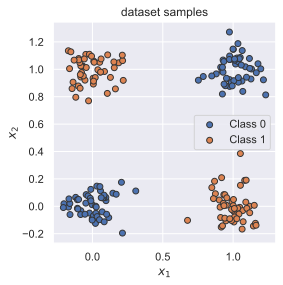

In [53]:
visualize_samples(dataset.data, dataset.label)
plt.show()

## The DataLoader class:
torch.utils.data.DataLoader represents a Python iterable over a dataset with support for automating batching, multi-process data loading. 
- batch_size : Number of samples to stack per batch.
- shuffle: If true, the data is returned in a random order.
- num_workers: Number of workers to load data. The default value is 0, means the data will be loaded in the main processor which is slow for large datasets like images. 
- persistent_workers: 
- drop_last: If true the last batch is dropped. 
- collate_fn: A function that defines how elements per batch are stacked. By default Pytorch uses Pytorch tensors. Here, we will change it to jax Numpy arrays.

In [54]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size= 8, shuffle= True, collate_fn= numpy_collate)

In [57]:
# next(iter(...)) returns the first batch of the data loader.
# If shuffle is True, this will return a different batch every time we run this cell.
# for iterating over the whole data set, we just use for batch in data_loader.

data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.01990597  0.9399783 ]
 [ 1.1628616  -0.13801014]
 [ 1.117944   -0.04691757]
 [ 0.7876104   0.9474245 ]
 [ 0.9236741   0.8195118 ]
 [-0.05767713  1.0755391 ]
 [ 0.10830513  1.1053802 ]
 [-0.10708925  0.04824724]]
Data labels (8,) 
 [1 1 1 0 0 1 1 0]


## Optimization

During the training, we follow the following steps:
1. Get a batch of the data from the data loader.
2. Obtain the predictions from the model for the batch.
3. Calculate the loss based on the diffrence between predictions and the labels.
4. Backppropagation: calculate the gradients for every parameters with respect to the loss.
5. Update the parameters of the model in the direction of the gradients.

For updating the parameters, we will use optax library. Optax library offers common deep learning optimizers (SGD, Adam, Adagrad, RMSProp, etc) and utilities (gradient clipping, weight decay, etc).

In [58]:
try: 
    import optax

except ModuleNotFoundError: # Install if optax is missing
    !pip install --quiet optax
    import optax
    

In [59]:
optimizer = optax.sgd(learning_rate= 0.1)

Flax offers the flax.trainng package. We can use TrainState to bundle the parameters, the optimizer, and the forward step of the model.

In [60]:
from flax.training import  train_state
model_state = train_state.TrainState.create(
    apply_fn = model.apply,
    params = params,
    tx = optimizer,
)

## Loss function:
We will use the Binary entropy loss function (BCE) 
$$L_{BCE} = -\sum_i\left[y_i\log x_i + (1-y_i)\log(1-x_i)\right]$$

optax offers optax.sigmoid_binary_cross_enropy(logits, labels), We calculate the loss on the logits instead of the sigmoid outputs for numerical stability. 

In [61]:
def calculate_loss_acc(state, params, batch):
    data_inputs, labels = batch
    logits = state.apply_fn(params, data_inputs).squeeze(axis = -1)
    pred_labels = (logits>0).astype(jnp.float32)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [62]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.7328718, dtype=float32), Array(0.5, dtype=float32))

In [63]:
@jax.jit
def train_step(state, batch):
    # gradient function.
    grad_fn = jax.value_and_grad(
        calculate_loss_acc, # function to calculate loss
        argnums = 1, # calculate the gradients with respect to parameters,
        has_aux = True # also returns acc.
    )

    (loss, acc), grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads = grads)
    return state, loss, acc

In [65]:
# Evaluation function. Here we dont need to calculate gradients only acc.
@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [66]:
# lets create a bigger dataset
train_dataset = XORDataset(size = 2500, seed= 42)
train_data_loader = data.DataLoader(train_dataset, batch_size= 128, shuffle= True, collate_fn= numpy_collate)

In [67]:
def train_model(state, data_loader, num_epochs = 100):
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
    return state

In [68]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs= 100)

  0%|          | 0/100 [00:00<?, ?it/s]

flax.training package provides us with nice utilities for saving the trained model.

In [69]:
from flax.training import checkpoints

In [73]:
import os
ckpt_dir = os.path.abspath('my_checkpoints/')
checkpoints.save_checkpoint(
    ckpt_dir= ckpt_dir, # folder to save.
    target = trained_model_state, # what to save. To only save the model params, use model_state.params.
    step = 100, # training step other metrix to save best model on.
    prefix = 'my_model', # checkpoint file name prefix
    overwrite = True, # overwrite existing checkpoint files.

)

'/Users/athani/Desktop/Deep learning/my_checkpoints/my_model100'

In [74]:
load_model_state = checkpoints.restore_checkpoint(
    ckpt_dir = ckpt_dir,
    target = model_state, # optional
    prefix = 'my_model' # checkpoint file name prefix
)

In [75]:
# Evaluation.
test_dataset = XORDataset(size= 500, seed= 123)
test_data_loader = data.DataLoader(test_dataset, batch_size= 128, shuffle= False, drop_last= False, collate_fn= numpy_collate)

In [76]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])

    # weighted average since some batches might be smaller.
    acc = sum([a*b for a, b in zip(all_accs, batch_sizes)])/sum(batch_sizes)
    print(f'accuracy of the model: {100.0*acc:4.2f}%')

In [77]:
eval_model(trained_model_state, test_data_loader)

accuracy of the model: 100.00%


### Binding Model Parameters

In [78]:
# we can bind the instance model of our SimpleClassifier class to our trained parameter.
trained_model = model.bind(trained_model_state.params)

# with the model being binded to the parameters, we can use it to apply it to any input.
data_input, labels = next(iter(data_loader))
out = trained_model(data_input) # instead of just using model.apply(params, inp)
out.shape


(8, 1)

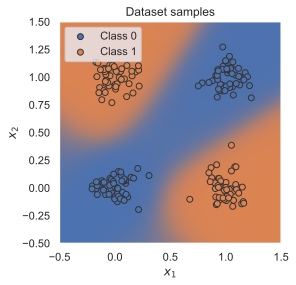

In [83]:
## Visualizing classification boundaries.
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()


    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))

    x1 = jnp.arange(-0.5, 1.5, step= 0.01)
    x2 = jnp.arange(-0.5, 1.5, step= 0.01)

    xx1, xx2 = jnp.meshgrid(x1, x2, indexing= 'ij')
    model_inputs = np.stack([xx1, xx2], axis = -1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1-preds)*c0[None, None] + preds*c1[None, None] # specifying None in a dimension creates one.
    output_image = jax.device_get(output_image) # convert to numpy array.
    plt.imshow(output_image, origin= 'lower', extent= (-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()
